In [17]:
import pandas as pd
import openpyxl
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [18]:
df_retail = pd.read_excel('Online Retail.xlsx', index_col=0, engine='openpyxl')
df_retail = df_retail.dropna(subset = ['Description'])
df_retail = df_retail.astype({'Description': str}) # to be sure that it's gonna read and evaluate the data. 
df_retail_list = df_retail.groupby(['InvoiceNo'])['Description'].apply(list).to_list() # to create a baskets lists

print('Number of transactions', len(df_retail_list))
print('Number of unique items', len(set(sum(df_retail_list, []))))

Number of transactions 24446
Number of unique items 4223


In [19]:
encoder = TransactionEncoder()
encoded_array = encoder.fit(df_retail_list).transform(df_retail_list)
    #The fit method analyzes the transactions data to identify all the unique items present across all transactions.The transform method then uses this vocabulary to create the one-hot encoded array.For each transaction, it creates a row in the array.For each unique item, it creates a column.
df_itemsets = pd.DataFrame(encoded_array, columns=encoder.columns_)

In [20]:
frequent_items = apriori(df_itemsets, min_support=0.025, use_colnames=True)
print(frequent_items)

      support                                           itemsets
0    0.039311                           (6 RIBBONS RUSTIC CHARM)
1    0.025444                  (60 CAKE CASES VINTAGE CHRISTMAS)
2    0.034198                      (60 TEATIME FAIRY CAKE CASES)
3    0.025321                   (72 SWEETHEART FAIRY CAKE CASES)
4    0.040947                       (ALARM CLOCK BAKELIKE GREEN)
..        ...                                                ...
131  0.027939  (JUMBO BAG RED RETROSPOT, JUMBO SHOPPER VINTAG...
132  0.029984  (JUMBO BAG RED RETROSPOT, JUMBO STORAGE BAG SUKI)
133  0.026507  (LUNCH BAG RED RETROSPOT, LUNCH BAG  BLACK SKU...
134  0.025076  (LUNCH BAG RED RETROSPOT, LUNCH BAG PINK POLKA...
135  0.025117  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...

[136 rows x 2 columns]


In [21]:
rules = association_rules(frequent_items, metric="confidence", min_threshold=0.3)
print(rules.iloc[:,:7])

                            antecedents                          consequents  \
0           (ALARM CLOCK BAKELIKE RED )         (ALARM CLOCK BAKELIKE GREEN)   
1          (ALARM CLOCK BAKELIKE GREEN)          (ALARM CLOCK BAKELIKE RED )   
2     (GREEN REGENCY TEACUP AND SAUCER)     (PINK REGENCY TEACUP AND SAUCER)   
3      (PINK REGENCY TEACUP AND SAUCER)    (GREEN REGENCY TEACUP AND SAUCER)   
4     (GREEN REGENCY TEACUP AND SAUCER)   (ROSES REGENCY TEACUP AND SAUCER )   
5    (ROSES REGENCY TEACUP AND SAUCER )    (GREEN REGENCY TEACUP AND SAUCER)   
6             (JUMBO BAG RED RETROSPOT)            (JUMBO BAG PINK POLKADOT)   
7             (JUMBO BAG PINK POLKADOT)            (JUMBO BAG RED RETROSPOT)   
8             (JUMBO BAG RED RETROSPOT)  (JUMBO SHOPPER VINTAGE RED PAISLEY)   
9   (JUMBO SHOPPER VINTAGE RED PAISLEY)            (JUMBO BAG RED RETROSPOT)   
10            (JUMBO BAG RED RETROSPOT)             (JUMBO STORAGE BAG SUKI)   
11             (JUMBO STORAGE BAG SUKI) 

In [22]:
rules_plot = pd.DataFrame()
rules_plot['antecedents']= rules['antecedents'].apply(lambda x: ','.join(list(x))) #','.join(...): This takes the list of items and joins them into a single string, using a comma (,) as the separator.
rules_plot['consequents']= rules['consequents'].apply(lambda x: ','.join(list(x)))
rules_plot['lift']= rules['lift'].apply(lambda x: round(x,2))

pivot = rules_plot.pivot(index='antecedents', columns='consequents', values='lift')
print(pivot)

consequents                        ALARM CLOCK BAKELIKE GREEN  \
antecedents                                                     
ALARM CLOCK BAKELIKE GREEN                                NaN   
ALARM CLOCK BAKELIKE RED                                14.59   
GREEN REGENCY TEACUP AND SAUCER                           NaN   
JUMBO BAG PINK POLKADOT                                   NaN   
JUMBO BAG RED RETROSPOT                                   NaN   
JUMBO SHOPPER VINTAGE RED PAISLEY                         NaN   
JUMBO STORAGE BAG SUKI                                    NaN   
LUNCH BAG  BLACK SKULL.                                   NaN   
LUNCH BAG PINK POLKADOT                                   NaN   
LUNCH BAG RED RETROSPOT                                   NaN   
PINK REGENCY TEACUP AND SAUCER                            NaN   
ROSES REGENCY TEACUP AND SAUCER                           NaN   

consequents                        ALARM CLOCK BAKELIKE RED   \
antecedents              

In [23]:
antecedents = list(pivot.index.values)
consequents = list(pivot.columns)

In [24]:
pivot = pivot.to_numpy() # creating array without index and columns

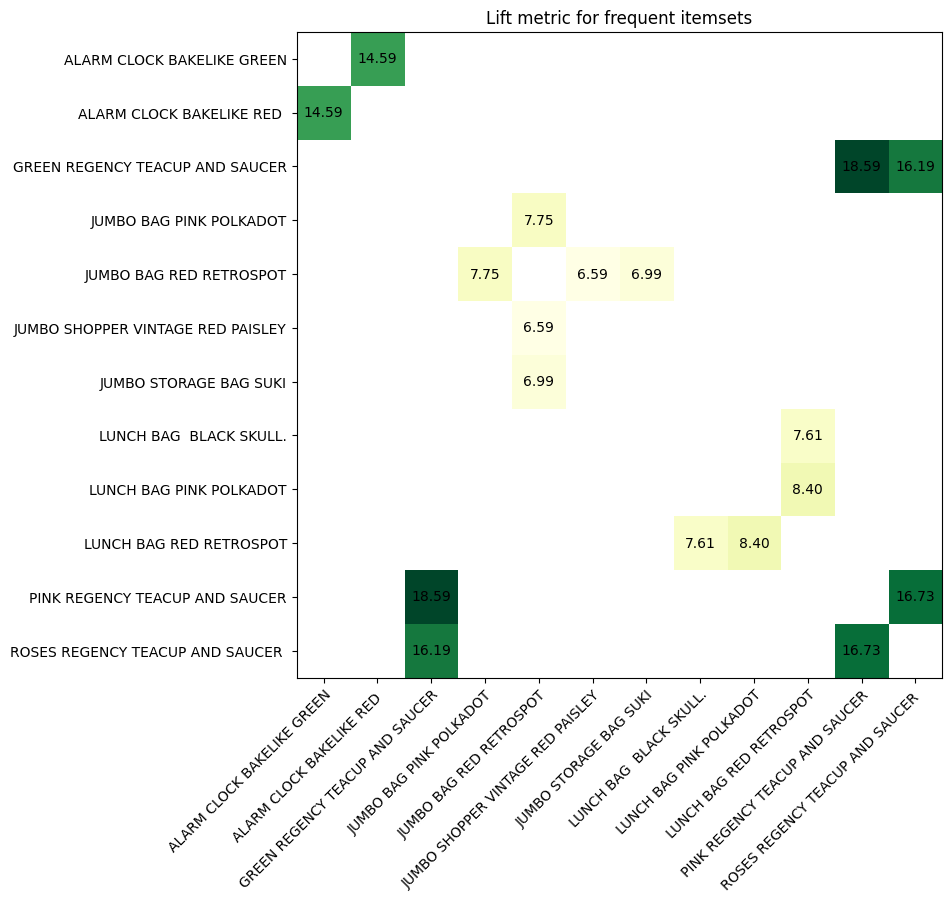

In [ ]:
fig, ax = plt.subplots(figsize=(len(consequents) * 0.8, len(antecedents) * 0.8))
im = ax.imshow(pivot, cmap='YlGn')

ax.set_xticks(np.arange(len(consequents)))
ax.set_yticks(np.arange(len(antecedents)))
ax.set_xticklabels(consequents)
ax.set_yticklabels(antecedents)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
textcolors = ["black", "white"]
threshold = Normalize(vmin=pivot.min(), vmax=pivot.max())(pivot).mean()

for i in range(len(antecedents)):
    for j in range(len(consequents)):
        if not np.isnan(pivot[i, j]):
            color = textcolors[int((Normalize(vmin=pivot.min(), vmax=pivot.max())(pivot[i, j]) < threshold))]
            text = ax.text(j, i, f"{pivot[i, j]:.2f}", ha="center", va="center", color=color, fontsize=10) # 2f formats to 2 decimal places

ax.set_title("Lift metric for frequent itemsets")
fig.tight_layout()
plt.show()